# 6장 학습 관련 기술

- 매개변수의 최적화 방법
- 가중치 매개변수 초깃값
- 하이퍼파라미터 설정방법

### 오버피팅의 대응책

- 가중치 감소
- 드롭아웃

### 매개변수의 갱신 방법
- 확률적 경사 하강법(SGD) 다시 보기
- 모멘텀(Momentum)
- AdaGrad
- Adam

## 확률적 경사하강법(SGD)

In [17]:
class SGD:
    def __init__(self, lr=0.01):
        """lr은 학습률"""
        self.lr = lr
        
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

$$ W \rightarrow W - \eta\frac{\delta L}{\delta W}  $$


W는 갱신할 가중치 매개변수, 우변의 편미분은 W에 대한 손실함수의 기울기, 에타는 학습률이다. SGD에는 단점이 있는데 학습이 비효율적이다.

![Gradient Descent Optimization Algorithms at Long Valley](http://i.imgur.com/2dKCQHh.gif?1)

![Gradient Descent Optimization Algorithms at Saddle Point](http://i.imgur.com/NKsFHJb.gif?1)

![Gradient Descent Optimization Algorithms at Beale's Function](http://i.imgur.com/pD0hWu5.gif?1)

## 모멘텀

$$ 
v \leftarrow \alpha v - \eta \frac{\delta L}{\delta W} \\
W \leftarrow W + v 
$$

V는 물리에서 말하는 속도에 해당한다


참고문헌에서 본 코드로 보면 간단하다
SGD(Vanilla update)
```python
x += - learning_rate * dx 
```

Momentum update
```python
v = mu * v - learning_rate * dx # integrate velocity
x += v # integrate position
```

각각의 매개변수 갱신방법에 대한 그래프 모양은 위의 그림을 참고하도록 하자.


In [18]:
class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

## AdaGrad
신경망 학습에서는 당연하게도 학습률이 중요하다. 너무 작으면 학습시간이 길어지고, 크면 발산하여 올바른 학습을 할 수 없기 때문. 이를 해결하는 간단한 방법은 일괄적으로 낮추는 것.

AdaGrad는 개별 매개변수에 adative하게 학습률을 조정하여 학습을 진행한다

$$ h \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} $$
$$ W \leftarrow W + \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W}  $$

h라는 새로운 변수가 나오는데, 기존 기울기 값을 제곱하여 더해줌 (\odot은 행렬의 원소별 곱셈을 의미함), 매개변수를 갱신할때 \frac{1}{\sqrt{h}}를 곱해 학습률을 조정함

즉 AdaGrad는 과거의 기울기를 제곱하여 계속 더해간다. 그래서 학습을 진행할 수록 강도가 약해짐.

RMSProp은 AdaGrad의 단점을 개선한 방법. 먼 과거의 기울기는 서서이 잊고 새로운 기울기 정보를 크게 반영한다. 이를 지수이동평균이라 하는데, 이것 또한 위에 그림이 있으니 참고하도록 하자.

```python
# RMSProp을 코드로 표현
cache = decay_rate * cache + (1 - decay_rate) * dx**2
x += - learning_rate * dx / (np.sqrt(cache) + eps)
```
참고문헌의 설명에 따르면.. 
> decay_rate는 초모수이고 보통 [0.9, 0.99, 0.999] 중 하나의 값을 취한다. 주목할 점은 += 업데이트는 Adagrad와 동등하지만, cache가 “어디선가 샌다”. 따라서 RMSProp은 여전히 각 웨이트값을 (그것의 과거 그라디언트) 값으로) 조정하여 성분별로 실질 학습속도를 비슷하게 만드는 효과는 갖고 있지만, Adagrad처럼 학습 속도가 단조적으로 줄지는 않는다. 

In [20]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## Adam

RMSProp과 AdaGrad를 합친것 같은 알고리즘. 다른 문서에서도 이렇게 설명하는 것으로 보인다. 하이퍼파라미터의 '편향 보정'이 진행된다는 것이 특징!



```python
# Adam을 코드로 간단히 표현
m = beta1*m + (1-beta1)*dx
v = beta2*v + (1-beta2)*(dx**2)
x += - learning_rate * m / (np.sqrt(v) + eps)
```
참고문헌의 설명에 따르면..
> 업데이트는 RMSProp의 업데이트 방식과 정확히 같아 보이는데, 그냥 (노이즈가 껴있을 수도 있는) 그라디언트 dx 대신에 “안정화된” 버전인 m이 사용되었다는 점이 다르다. 논문에 따르면 추천되는 초모수값들은 eps = 1e-8, beta1 = 0.9, beta2 = 0.999이다. 실전에서 Adam은 기본 알고리즘으로 추천되고 있고, 가끔은 RMSProp보다 조금 더 잘 하기도 한다. 그러나 SGD+Nesterov Momentum도 대안으로 해볼만 하다. Adam 업데이트 절차에는 편향 보정(bias correction) 매커니즘이 반영되어 있는데, 벡터 m,v가 나중에 완벽하게 “워밍업” 되기 전에 (iteration의 처음 몇 스텝에서) 초기화되어 0에 편향되어 있다는 점을 보상하기 위해서이다. 

어느 갱신방법을 이용할 것인가? 라는 챕터인데. 책에서는 SGD를 쓴다고 했다. NGD(SGD 변형)와 Adam을 주로 많이 쓴다.
실제 MNIST 데이터 셋으로 갱신방법을 비교하면 SGD가 가장 느리다. 물론 문제에 따라 다르겠지만 일반적으로 느릴것같다.

## 가중치의 초깃값

초깃값을 0으로 하면 학습이 제대로 이루어지지 않음.가중치를 작게 만들고 싶으면, 초기값도 작은 값부터 시작해야한다. 지금까지 가중치의 초깃값은 정규분포에서 생성되는 값을 0.01배 한 값을 사용하였다. 즉, 표준편차가 0.01인 정규분포.

예를 들어, 2층 신경망에서 첫 번째와 두 번채 층의 가중치가 0이라고 가정할 때, 순전파 입력치의 가중치가 0이기 때문에, 두번째 층의 뉴런에 모두 같은 값이 전달됩니다. 이렇게 되면, 역전파 시에 두 번째 층의 가중치가 모두 동일하게 갱신됩니다. 이는 가중치를 여러 개 쓰는 것을 의미없게 만듭니다.

이를 막기 위해서는, 초깃값을 무작위로 설정해야함

## 은닉층에서는 어떤일이?

각 층의 활성화 값의 히스토그램을 확인하면 활성화 값이 0과 1에 치우쳐져 분포되어 있음. 활성화 함수나 초깃값을 바꿔서 실행해본결과 고르게 분포되어 있지 않다는 것을 알 수 있음. 이는 __표현력 제한 문제__에 빠져 있다는 뜻이된다.

## ReLU를 사용할 때의 가중치 초깃값

Xavier 초깃값은 활성화 함수가 선형 것을 전제로 이끈 결과. 그렇기 때문에, ReLU를 사용할때는 ReLU에 특화된 초깃값을 이용하라고 권장. 
이를 He 초깃값이라고 하는데, 앞 노드가 n개일때, 표준편차가 \sqrt\frac{2}{n}인 정규분포를 사용하는 것.

He 초깃값을 사용하면, 활성화 함수 결과값이 모든 층에 균일하게 분포되기 때문에, 층이 깊어져도 적절한 값이 나올 것으로 기대할 수 있음

정리하면.. 
- 활성화 함수가 sigmoid나 tanh같이 S자 모양 곡선인 경우 : Xavier 초깃값이 적당함
- 활성화 함수가 ReLU인 경우 : He

활성화 값들을 잘 __제어__(표현력 제한 해결)해야 학습이 잘된다.(결과가 잘 나옴)



## 배치 정규화
가중치의 초깃값을 적절히 설정하면 각 층의 활성화 값 분포가 적당히 퍼지면서 학습이 잘된다는 것을 확인할 수 있었다. 2015년에 나왔지만 가중치 초깃값 선택하는 것보다 결과가 잘 나와 이 방법을 많이 사용함.

요약하면 다음과 같은 장점이 있다.

- 학습을 빨리 진행할 수 있다. -> 중요하다
- __초깃값에 크게 의존하지 않는다.__ -> 초깃값 결과에 따라 활성화 값이 다르기 때문
- __오버피팅을 억제.__

기본적인 아이디어는 행렬곱과 활성화 함수 처리과정 중간에, 배치 정규화 계층(Batch Norm)을 삽입하여, 활성화값이 적당히 분포되도록 조정하는 것이다.

미니배치 단위로 정규화를 진행하는데, 데이터 분포가 평균이 0, 분산이 1이 되도록 정규화한다. 수식은 다음과 같다.
$$ \mu_B \leftarrow \frac{1}{m} \sum^{m}_{i=1} {x_i} $$

$$ \sigma^2_B \leftarrow \frac{1}{m} \sum^{m}_{i=1} {x_i} \left( x_i - \mu_B \right)^2 $$

$$ \hat{x}_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}} $$


미니배치 m개의 입력 데이터에 대해 평균과 분산을 구하고, 그 값을 가지고 어파인 출력값을 평균 0, 분산 1인 데이터로 정규화하는 식입니다.

또한 배치 정규화 계층마다, 정규화된 데이터에 확대와 이동 변환을 수행합니다. 수식으로는 다음과 같다.
$$ y_i \leftarrow \gamma \hat{x}_i + \beta $$

평균과 분산을 구한 다음, 입력 데이터를 평균이 0, 분산이 1이 되게 정규화함. 엡실론은 0으로 나누는 것을 방지하는 역할(세번째 식)

감마가 확대(scale)를 베타가 이동(shift)를 수행함. 처음에는 각각 1과 0에서 시작. 이는 감마 1일 경우 1배 확대를 의미. 베타가 0이라는 것은 이동하지 않는다는 것을 의미한다. 학습하면서 적합한 값으로 조정해나간다. 

## 바른 학습을 위해
오버피팅의 경우 두 경우에 일어난다 
- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음

오버피팅의 경우 훈련데이터를 사용하여 측정한 정확도는 100%에 가깝게 나타날 수 있지만, 시험데이터에 대해선 큰 차이를 보일 수 있다. 즉 훈련데이터에만 적응해버리고 실제에는 대응하지 못하는 것이다.

###  가중치 감소

학습 과정에서 큰 가중치에 대해서는 큰 페널티를 부과하여 오버피팅을 억제하는 방법. 신경망 학습의 목적은 __손실 함수의 값을 줄이는 것__이었음. 이 때, 가중치의 제곱(L2 법칙)을 손실 함수에 더하면 가중치가 커지는 것을 억제할 수 있다.

가중치를 W라고 하면

1. 가중치 감소를 구한다 : 1/2 \lambda W^2
2. 손실 함수 <- 손실함수 + 1/2 \lambda W^2
    여기서 람다는 정규화의 세기를 조정하는 하이퍼파라미터. 람다를 크게 설정할수록 큰 가중치에 대한 패널티가 커집니다.
    앞의 1/2은 미분결과인 \lambda W를 조정하는 상수
가중치 감소는 모든 가중치 각각의 손실 함수에 1/2 \lambda W^2를 더합니다. 따라서 가중치의 기울기를 구하려면, 오차역전파법에 따른 결과에 정규화 항을 미분한 \lambda W를 더합니다.

\lambda를 0.1로 가중치 감소를 적용하면 __여전히 정확도에는 차이가 있을 수 있다.__ __오버피팅을 억제__하는데에는 효과적이다.

#### L2 법칙
L2 법칙은 각 원소(가중치)의 제곱들을 더한것에 해당. L1과 L MAX 법칙도 있다. 
- L1 법칙 : 절댓값의 합
- LMax 법칙 : 각 원소의 절댓값 중 가장 큰 것에 해당

### 드롭아웃(Dropout)

신경망 모델이 복잡해지면 가중치 감소만으로 대응하기 어려워짐. 위에서 강조한 문구에서 봤듯이 여전히 정확도에 차이가 있을 수 있음.

드롭아웃은 뉴런을 임의로 삭제하면서 학습하는 방법. -> 훈련때, __훈련하면서__ 은닉층의 뉴련을 __무작위로 골라 삭제__한다. 시험할때는 각 뉴런에 출력에 훈련때 삭제한 비율을 곱하여 출력한다.

코드에서 중요한 부분은, 훈련시에 순전파 때마다 `self.mask`에 삭제할 뉴런을 `False`로 표시한다는 것. self.mask는 x와 같은 배열을 무작위로 생성하고
`dropout_ratio`보다 큰 원소만 `True`로 설정한다. 즉, __순전파 때 통과한 뉴런__은 역전파 때도 신호를 통과하고, 통과하지 못한 뉴런은 역전파 때도 통과를 못한다.

In [ ]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

=== epoch:265, train acc:0.593333333333, test acc:0.5069 ===
train loss:1.21242923261
train loss:1.09799599006
train loss:1.14916591288
=== epoch:266, train acc:0.59, test acc:0.5084 ===
train loss:1.29893413033
train loss:1.20609384777
train loss:1.32107256127
=== epoch:267, train acc:0.6, test acc:0.5116 ===
train loss:1.27398699263
train loss:1.18790324154
train loss:1.19147481293
=== epoch:268, train acc:0.6, test acc:0.5126 ===
train loss:1.1653515149
train loss:1.18439729692
train loss:1.17710308736
=== epoch:269, train acc:0.603333333333, test acc:0.5129 ===
train loss:1.08449885861
train loss:1.223138175
train loss:1.12488930364
=== epoch:270, train acc:0.603333333333, test acc:0.5124 ===
train loss:1.20181991477
train loss:1.35231642265
train loss:1.27432255484
=== epoch:271, train acc:0.606666666667, test acc:0.5185 ===
train loss:1.1934731914
train loss:1.1777186678
train loss:1.08532512483
=== epoch:272, train acc:0.61, test acc:0.5207 ===
train loss:1.15013578917
train los

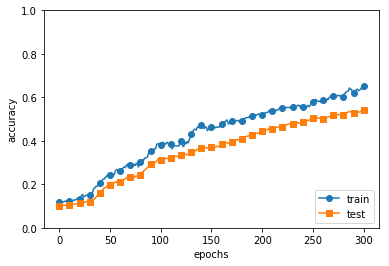

In [36]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


그래프를 보면,
- 드롭아웃 적용시, 훈련 데이터에 대한 정확도가 1.0에 도달하지 못했다.
- __훈련 데이터와 실제 데이터 사이의 정확도 차이가 줄었다.__

## 앙상블 학습?

앙상블 학습은 개별적으로 학습시킨 __여러 모델의 출력을 평균 내어 추론하는 방식__이다.

아이디어는 데이터 집합에 대해 성능이 가장 좋은 학습 모델을을 고르는 것이 아니라 여러가지 다양한 모델을 모두 이용해서 얻은 결과를 조합해보는 것. 다시 말해, 기계 학습의 분류 방법을 통해 여러개의 분류기를 생성하고, 그 예측을 결함합으로써 새로운 가설을 학습하는 방법이다.

참고문헌에 따르면..
> 학습 알고리즘을 조작하여 다양한 분류기를 생성한 후 다수결(Majority Voting)이나 가중치 투표(Weighted Voting)에 의하여 예측값을 결합한다. 이러한 앙상블 학습을 하는 대표적인 방법으로 부스팅(Boosting)과 배깅(Bagging)이 있다. 배깅과 부스팅은 학습 데이터를 샘플링하여 다양한 학습 데이터를 생성하며, 하나의 학습 알고리즘을 적용하여 다양한 분류기를 생성한다.
하나의 데이터 세트에 다양한 학습 알고리즘을 적용하여 다양한 분류기를 생성하는 앙상블 학습 방법도 있다. 이럴 경우, 예측값을 결합하기 위해 투표보다는 좀 더 복잡한 방법을 사용하기도 한다. 대표적인 방법으로 스태킹(Stacking)이 있다. 스태킹은 다양한 학습 알고리즘을 이용하여 분류기를 생성하고 이 분류기들의 예측값을 결합하는 분류기를 추가로 학습한다.
또 다른 방법으로는 전문가의 혼합(Mixture of  Experts) 방법이 있다. 이 방법은 각각의 분류기에 다른 지역을 할당하여 성능을 향상시키는 방법이다[4]. 이 방법에서는 각각의 분류기뿐만 아니라 분류기에 지역을 할당하기 위한 게이트 함수(Gating Function)도 학습해야 한다.

정리하면 
1. 훈련 집합의 조작(배깅, 부스팅)
2. 입력 특징의 조작(랜덤 포레스트)
3. 클래스 레이블의 조작
4. 학습 알고리즘의 조작

앙상블은 모델간 다양성이 있는 경우 더 좋은 결과를 낸다. 앙상블 학습은 조합하는 모델간의 다양성을 증진시키려고 한다고 한다.


## 적절한 하이퍼파라미터 값 찾기

하이퍼파라미터는 다수 등장. 예를 들어, 
- 각 층의 뉴런 개수
- 배치 크기
- 매개변수 갱신 시의 학습률과 가중치 감소

쉽게 말하면 __학습시 중요한 요소들__이다.

### 하이퍼파라미터 최적화

하이퍼파라미터 최적화의 핵심은, 하이퍼파라미터 ‘최적 값’이 존재하는 범위를 조금씩 줄여 가는 것.
순서는
1. 대략적인 범위를 설정
2. 무작위로 하이퍼파라미터 값을 골라낸다(샘플링)
3. 샘플링한 하이퍼파라미터 값을 가지고 학습하고, 검증 데이터로 정확도를 평가(에폭은 작게 설정)
4. 정확도를 살피면서 2~3번을 여러 번 반복하여(100회 등) 최적값의 범위를 좁혀간다.
범위는 __대략적__으로 지정하는 것이 효과적이다. 실제로도 0.001에서 1000사이와 같이, 10의 계승 단위로 범위를 지정합니다. 이를 로그 스케일로 지정한다고 한다.

딥러닝 학습에는 오랜 시간이 걸립니다. 1~3번을 계속해서 반복해야 하기 때문에, 나쁠 듯한 값은 일찍 포기하는 것이 좋습니다. 그래서 에폭을 적게 하여 여러 1회 평가에 걸리는 시간을 단축하는 것이 효과적이다. 

#### 베이즈 최적화 
좀 더 세련된 기법이라고 한다. 참고문헌을 보도록 하자.

### 하이퍼 파라미터 최적화 구현하기 
무작위로 추출한 값을 가지고 학습을 시작. 그 후에는 다양한 하이퍼파라미터 값으로 학습을 반복하여, 신경망에 좋을 거 같은 값이 어디에 존재하는지 관찰한다.

```python
weight_decay = 10 ** np.random.uniform(-8, -4) # 가중치 감소 계수를 10^-8~10^-4 
lr = 10 ** np.random.uniform(-6, -2) # 학습률의 범위를 10^-6 ~ 10^-2
```

여러 번 학습을 한 후에, 학습이 잘 된 모델을 추출하여 그 때의 하이퍼파라미터 값을 확인한다.. 예를 들어, 학습이 잘 진행될 때의 학습률은 0.001~0.01 이고, 가중치 감소 계수는 10^−8, 10^−6 이라고 하면, 축소된 값을 가지고 다시 변수를 할당하여 학습을 반복한다. 이렇게 범위를 좁혀가다가, 특정 단계에서 최종 하이퍼파라미터 값을 선택한다.

# 참고하면 좋은 글들
- [Gradient Descent Optimization Algorithms 정리](http://shuuki4.github.io/deep%20learning/2016/05/20/Gradient-Descent-Algorithm-Overview.html)
- [CS231n Convolutional Neural Networks for Visual Recognition](http://aikorea.org/cs231n/neural-networks-3/#sgd)
- [CS231n Convolutional Neural Networks for Visual Recognition](http://aikorea.org/cs231n/optimization-1/)
- [베이지안 최적화](http://sanghyukchun.github.io/99/#gp-with-noisy-data)